In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, DenseNetworkGrid, set_seed

Main difference is testing star age learning

In [4]:
name = 'grid_12'
tracks = 'tracks_04'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [5]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

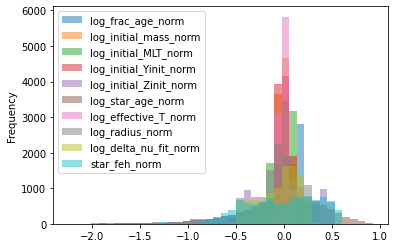

In [6]:
train.sample(n=10000).plot(kind='hist', bins=40, alpha=0.5)

In [14]:
x_cols = ['log_star_age_norm', 'log_initial_mass_norm', 'log_initial_MLT_norm',
          'log_initial_Yinit_norm', 'log_initial_Zinit_norm']
y_cols = ['log_effective_T_norm', 'log_radius_norm',
          'log_delta_nu_fit_norm', 'star_feh_norm']

<IPython.core.display.Javascript object>


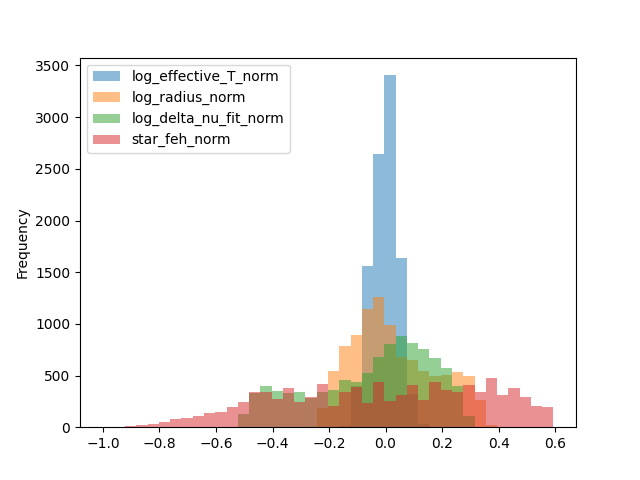

In [43]:
train.sample(n=10000).plot(kind='hist', y=y_cols, bins=40, alpha=0.5)

In [15]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 6020244
Length of validation data = 1505065


In [16]:
n_batches = np.arange(500, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[ 612  918 1093 1377 1836]


No matches, so we choose remainders less than 10

In [17]:
print(f'choose number of batches from:\n{n_batches[r<20]}')

choose number of batches from:
[ 522  524  533  543  551  568  585  607  612  615  626  662  753  852
  918  937 1093 1102 1214 1255 1285 1324 1377 1513 1599 1653 1704 1821
 1836 1845 1889]


We can afford to drop 20 points randomly and this gives us more choice for the number of batches. Since we've added more points we should think about keeping the number of batches fairly high. Let's choose 612

In [18]:
n_drop = r[n_batches==612]
n_drop

array([0])

In [19]:
seed = 101
train = train.sample(n=len(train)-n_drop, random_state=seed)

Double-check

In [20]:
len(train) % 612

0

In [21]:
depth = [5, 7]
width = [128, 256]
activation = ['relu']
batch_size = len(train)//612
regularization_l2 = [0.0, 1e-9, 1e-6]
optimizer = 'nadam'
loss = 'mse'
metrics = ['mae']

In [22]:
grid = DenseNetworkGrid(path=save_path, name=name, depth=depth, width=width,
                        activation=activation, batch_size=batch_size,
                        regularization_l2=regularization_l2)

grid.data

,depth,width,activation,batch_size,regularization_l2
name,,,,,
grid_12_0,5,128,relu,9837,0.000000e+00
grid_12_1,5,128,relu,9837,1.000000e-09
grid_12_2,5,128,relu,9837,1.000000e-06
grid_12_3,7,128,relu,9837,0.000000e+00
grid_12_4,7,128,relu,9837,1.000000e-09
grid_12_5,7,128,relu,9837,1.000000e-06
grid_12_6,5,256,relu,9837,0.000000e+00
grid_12_7,5,256,relu,9837,1.000000e-09
grid_12_8,5,256,relu,9837,1.000000e-06


In [23]:
grid.make_networks()

In [24]:
grid.build_all(len(x_cols), len(y_cols))

In [25]:
grid.compile_all(optimizer=optimizer, loss=loss, metrics=metrics)

In [26]:
grid.train_all(train, x_cols, y_cols, epochs=50, validation_data=val, validation_split=None,
               callbacks=['tensorboard'], network_kw={'nth_row': 5})

Add a function which plots history for all networks.

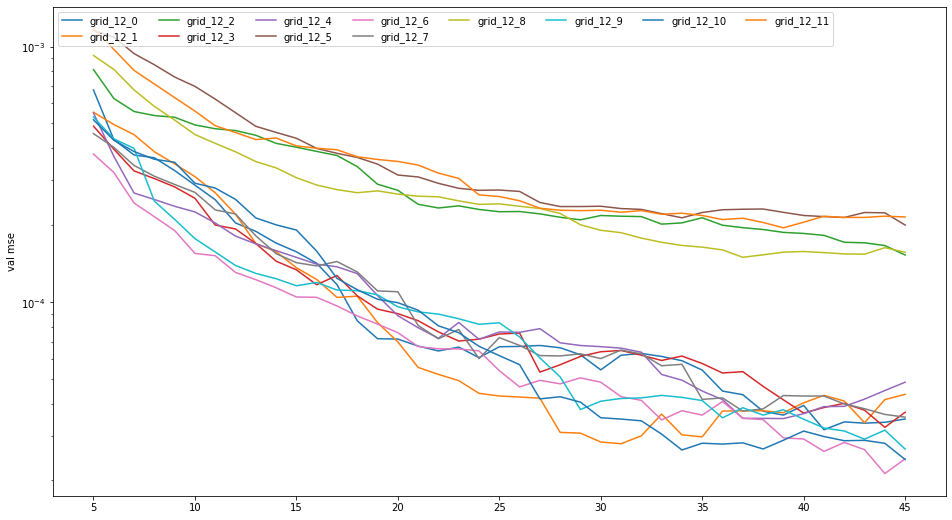

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))
filter_width = 10  # filter width in epochs

for network in grid.networks:
#     network.history.plot(ax=ax, x='epochs', y=['val_loss'], logy=True, alpha=0.5,
#                          label=[f'{network.name} val loss'])
    df = network.history
    y = np.convolve(network.history.val_loss, np.ones((filter_width,))/filter_width, mode='valid')
    ax.plot(df.iloc[filter_width//2:-filter_width//2+1].epochs, y, label=f'{network.name}')
ax.set_ylabel(f'val {loss}')
ax.set_yscale('log')

ax.legend(loc='upper left', ncol=8)

In [29]:
grid.evaluate_all(val.sample(n=5000))

,loss,mae
name,,
grid_12_0,0.000076,0.004663
grid_12_1,0.000034,0.003578
grid_12_2,0.000124,0.004033
grid_12_3,0.000089,0.005218
grid_12_4,0.000146,0.005682
grid_12_5,0.000133,0.002636
grid_12_6,0.000043,0.003230
grid_12_7,0.000031,0.003357
grid_12_8,0.000124,0.003801


In [30]:
import seaborn as sns

In [32]:
val = val.sample(n=20000)

In [33]:
df_dict = {}
for i, network in enumerate(grid.networks):
#     network = grid.networks[i]
    df_dict[network.name] = np.abs(network.predict(val, batch_size=network.batch_size) - \
                                   val[y_cols].reset_index(drop=True))

In [34]:
df_err = pd.concat(df_dict).reset_index(level=0).rename(columns={'level_0': 'name'})
df_err.head()

,name,log_effective_T_norm,log_radius_norm,log_delta_nu_fit_norm,star_feh_norm
0,grid_12_0,0.000325,0.000339,0.003964,0.000560
1,grid_12_0,0.001651,0.002615,0.000304,0.005844
2,grid_12_0,0.004366,0.003010,0.004516,0.001544
3,grid_12_0,0.003452,0.003424,0.003657,0.002201
4,grid_12_0,0.001108,0.001634,0.002294,0.000948


In [35]:
df_mae = pd.concat(df_dict).mean(axis=1).reset_index(level=0).rename(columns={'level_0': 'name', 0: 'mae'})
df_mae.head()

,name,mae
0,grid_12_0,0.001297
1,grid_12_0,0.002603
2,grid_12_0,0.003359
3,grid_12_0,0.003183
4,grid_12_0,0.001496


In [36]:
df_mae['log_mae'] = np.log10(df_mae['mae'])

In [37]:
order = df_mae.set_index('name').median(level=0).sort_values('log_mae', ascending=False).index

In [38]:
df_err.head()

,name,log_effective_T_norm,log_radius_norm,log_delta_nu_fit_norm,star_feh_norm
0,grid_12_0,0.000325,0.000339,0.003964,0.000560
1,grid_12_0,0.001651,0.002615,0.000304,0.005844
2,grid_12_0,0.004366,0.003010,0.004516,0.001544
3,grid_12_0,0.003452,0.003424,0.003657,0.002201
4,grid_12_0,0.001108,0.001634,0.002294,0.000948


In [39]:
df_err_col = df_err.set_index('name').stack().reset_index().rename(columns={'level_1': 'output',
                                                                0: 'abs_err'})

df_err_col['log_abs_err'] = np.log10(df_err_col['abs_err'])

<IPython.core.display.Javascript object>


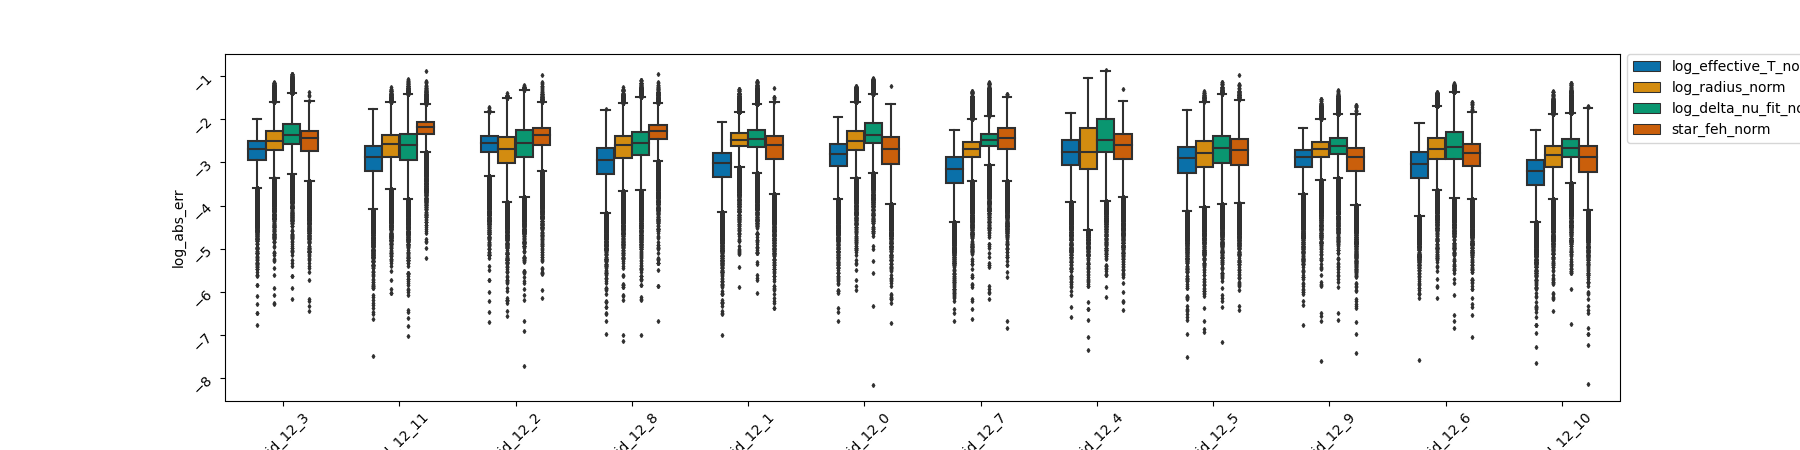

In [40]:
%matplotlib notebook

w = 1.5 * len(grid.data)
fig, ax = plt.subplots(figsize=(w, 4.5))
width = 0.15 * len(y_cols)
sns.boxplot(data=df_err_col, x='name', y='log_abs_err', hue='output',
            width=width, fliersize=2, color='C0', palette='colorblind',
            order=order, ax=ax, saturation=0.9)
# ax.set_yscale('log')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.02))

In [41]:
scores = grid.score_all(val, metric='absolute_error')

In [42]:
scores.xs('std', level=1)

,log_effective_T_norm,log_radius_norm,log_delta_nu_fit_norm,star_feh_norm
grid_12_0,0.001544,0.007575,0.011652,0.002290
grid_12_1,0.000915,0.004444,0.006911,0.002168
grid_12_2,0.001890,0.004244,0.006586,0.003850
grid_12_3,0.001363,0.008152,0.012704,0.002659
grid_12_4,0.002226,0.010985,0.017087,0.002957
grid_12_5,0.001673,0.003265,0.004885,0.003558
grid_12_6,0.001137,0.005779,0.009054,0.001545
grid_12_7,0.000842,0.003752,0.005764,0.003903
grid_12_8,0.001499,0.003899,0.005697,0.004504
grid_12_9,0.000874,0.002580,0.003999,0.001255
